# Loess and Exponential Smoothing
This nb is meant to demonstrate the model performance of load data, based on smoothing approaches. It also includes naive approaches to generate a baseline.<br><br>
<b>Context:</b>
<br>
Smoothing techniques typically are meant to extract signal from noise.
<br>
The ability of the smoother to extract high-quality signal depends on how well it can capture the signal's movement with time.
<br><br>
<b>Usage:</b><br>
The extracted signal can then be projected into the future, for forecasting purposes.

In [1]:
# Loading the data
import pandas as pd
load_long = pd.read_csv(r"C:\Users\singh\Desktop\TUD (All Semesters)\Courses - Semester 6 (TU Dresden)\Thesis Work\Exploratory Code\load_history_long.csv").sort_values(by = "timestamp")
load_long.head()

,zone_id,year,month,day,hour,load,timestamp
0,1,2004,1,1,00:30,16853.0,2004-01-01 00:30:00
14850,10,2004,1,1,00:30,23339.0,2004-01-01 00:30:00
16500,11,2004,1,1,00:30,90700.0,2004-01-01 00:30:00
28050,18,2004,1,1,00:30,200946.0,2004-01-01 00:30:00
9900,7,2004,1,1,00:30,136233.0,2004-01-01 00:30:00


In [2]:
# Checking if load values == 0 or not
load_long[load_long.load==0]

,zone_id,year,month,day,hour,load,timestamp
599279,4,2004,11,25,18:30,0.0,2004-11-25 18:30:00
476572,9,2007,10,4,14:30,0.0,2007-10-04 14:30:00
509572,9,2007,10,4,15:30,0.0,2007-10-04 15:30:00


In [5]:
# For the 3 observations, saved values would be -inf

import numpy as np
np.log(load_long.load)[599279]

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-inf

In [6]:
# Filtering for Zone 1, applying log transformation on load (after rescaling)
import numpy as np

load_long_z1 = load_long
load_long_z1["load_rs"] = load_long_z1.load / 1000
load_long_z1["log_load_rs"] = np.log(load_long_z1.load_rs)
load_long_z1 = load_long_z1.loc[load_long_z1.zone_id == 1,:].sort_values(by = "timestamp")
load_long_z1.head()

C:\Users\singh\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,zone_id,year,month,day,hour,load,timestamp,load_rs,log_load_rs
0,1,2004,1,1,00:30,16853.0,2004-01-01 00:30:00,16.853,2.824529
33000,1,2004,1,1,01:30,16450.0,2004-01-01 01:30:00,16.450,2.800325
66000,1,2004,1,1,02:30,16517.0,2004-01-01 02:30:00,16.517,2.804390
99000,1,2004,1,1,03:30,16873.0,2004-01-01 03:30:00,16.873,2.825715
132000,1,2004,1,1,04:30,17064.0,2004-01-01 04:30:00,17.064,2.836971


## Loess Smoothing
Essentially, it assigns localised weights similar to the KNN algorithm.<br>
[Reference](https://www.youtube.com/watch?v=Vf7oJ6z2LCc)

In [7]:
# Filtering for Jan 2004 (Zone 1)
load_long_z1_jan04 = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 1),["year","month","day","hour","timestamp","log_load_rs"]].sort_values(by = "timestamp").reset_index(drop=True)
load_long_z1_jan04.head()

,year,month,day,hour,timestamp,log_load_rs
0,2004,1,1,00:30,2004-01-01 00:30:00,2.824529
1,2004,1,1,01:30,2004-01-01 01:30:00,2.800325
2,2004,1,1,02:30,2004-01-01 02:30:00,2.804390
3,2004,1,1,03:30,2004-01-01 03:30:00,2.825715
4,2004,1,1,04:30,2004-01-01 04:30:00,2.836971


In [8]:
# Applying for Jan 2004 (Zone 1)
import statsmodels.api as sm

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04.index
y = load_long_z1_jan04.log_load_rs
lowess_vals = lowess(y, x)

Here, <i>non-parametric</i> lowess is used, meaning that a line is used for weighted least squares instead of a parabola.<br>
The implementation for a quadratic or higher-degree polynomial is not covered in statsmodels.

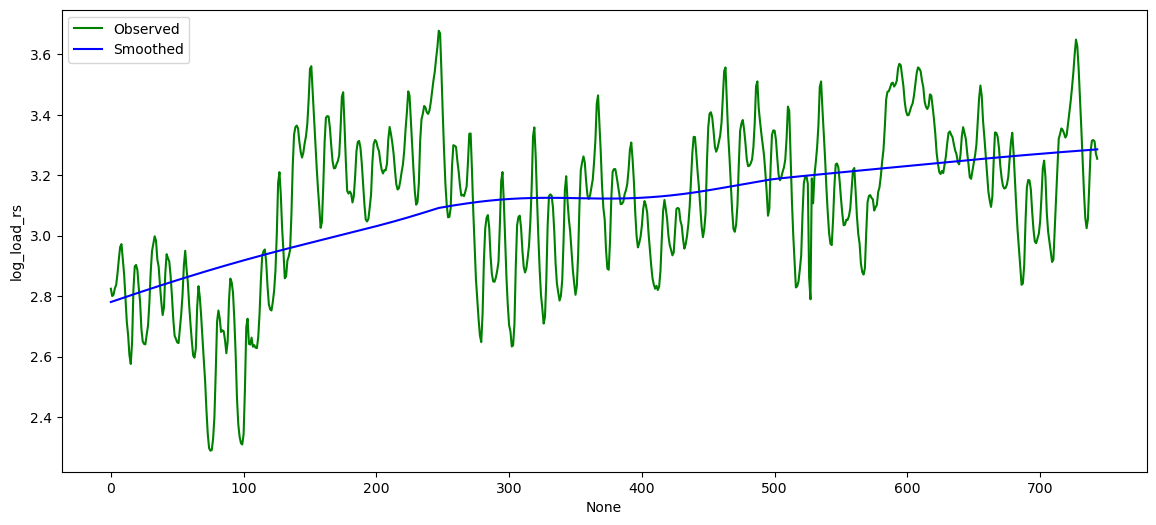

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=load_long_z1_jan04, x=load_long_z1_jan04.index, y="log_load_rs", ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jan04.index, y=pd.DataFrame(lowess_vals).loc[:,1], ax=ax, color = "blue", label= "Smoothed")
plt.show()

In [11]:
# Model fit
from sklearn.metrics import r2_score
r2_score(load_long_z1_jan04.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])

0.30378733476591746

In [12]:
# Length of the data
len(load_long_z1_jan04)

744

- Here, <i><b>frac</b></i> is the most important parameter.
- It determines the window size within which the localised regression is taking place.
<br>
- A smaller size means a narrower (more localised window). It will improve fit but has greater chances for overfitting.
<br>
- Default is 0.66 or 66% of the data (i.e. 66% of 744 = 491 obs)

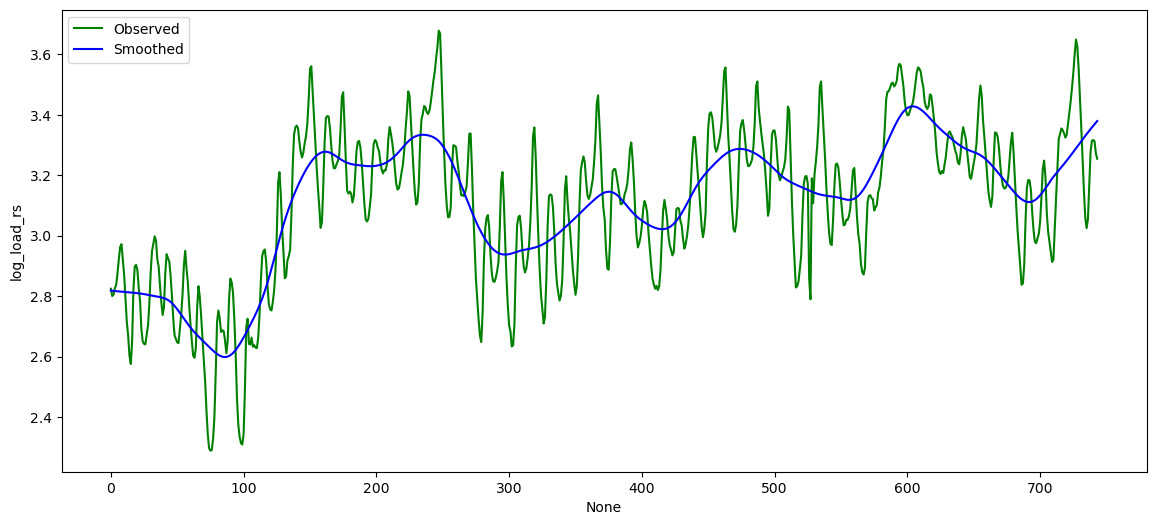

In [13]:
# Using 10% of total values i.e. 74 obs (setting values for other paramters to observe changes)

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04.index
y = load_long_z1_jan04.log_load_rs
lowess_vals = lowess(y, x, frac=0.1, it=0, is_sorted=True) 

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=load_long_z1_jan04, x=load_long_z1_jan04.index, y="log_load_rs", ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jan04.index, y=pd.DataFrame(lowess_vals).loc[:,1], ax=ax, color = "blue", label= "Smoothed")
plt.show()

In [14]:
# Model fit
r2_score(load_long_z1_jan04.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])

0.7003801928216067

For the graph to capture more precisely, an even lower value of <i>frac</i> is needed. To capture daily seasonality, window size must be 24 hours or less.

In [10]:
# 24 hr window in terms of % of data
2400/744

3.225806451612903

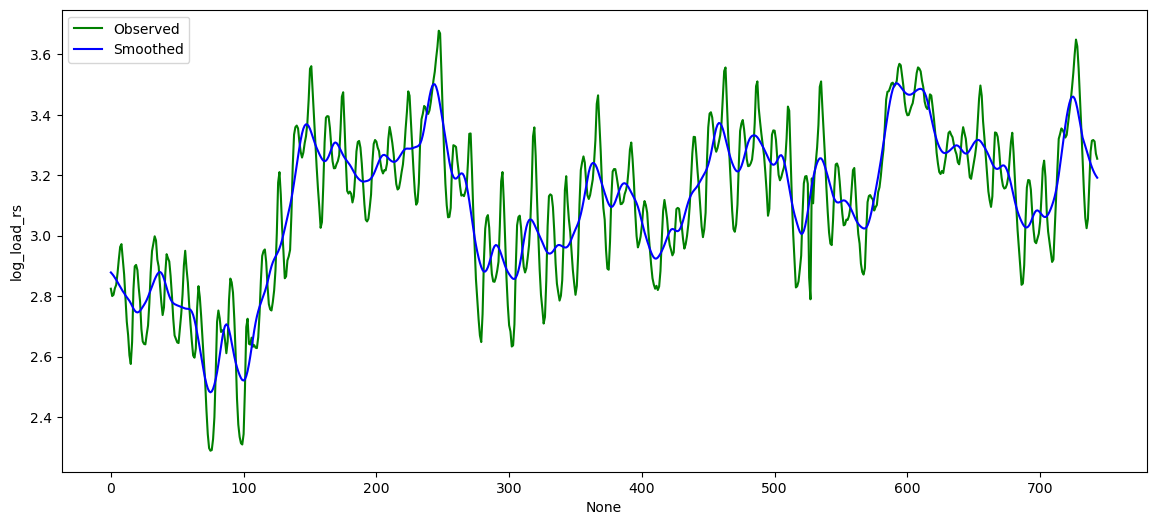

In [15]:
# Using 3.22% of total values i.e. 24 hours obs

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04.index
y = load_long_z1_jan04.log_load_rs
lowess_vals = lowess(y, x, frac=0.0322, it=0, is_sorted=True) 

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=load_long_z1_jan04, x=load_long_z1_jan04.index, y="log_load_rs", ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jan04.index, y=pd.DataFrame(lowess_vals).loc[:,1], ax=ax, color = "blue", label= "Smoothed")
plt.show()

In [16]:
# Model fit
r2_score(load_long_z1_jan04.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])

0.805423446727135

From observing the ACF plots for different portions of the year, it is seen that in many months the autocorrelation is strong till 6th lag.
<br>
However, for some months such as Apr and Oct the autocorrelation is not significant for the 5th and 6th lag.
<br>
Hence, it is well-suited to smooth values for 4 lags i.e. 4 observations on either side of the focal point.
<br><br>
<i> Window Size = 9 points (1 focal + 8 neighbouring points)

#### Testing on Last Week of Jan 2004 (Zone 1)
The smoothed loess curve is replicated and used for the test period.

In [17]:
# Defining train and test
load_long_z1_jan04_train = load_long_z1_jan04.loc[load_long_z1_jan04.day <= 24,:]
load_long_z1_jan04_test = load_long_z1_jan04.loc[load_long_z1_jan04.day > 24,:] # index is continued from training data

In [14]:
# 9 obs window in terms of % of training data
900/len(load_long_z1_jan04_train)

1.5625

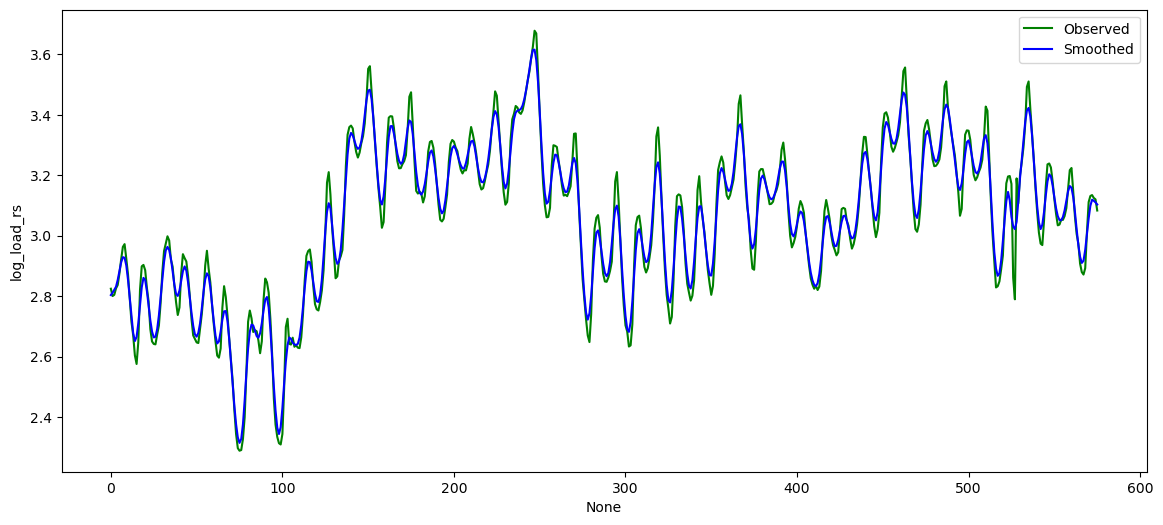

In [18]:
# Using 1.56% of total values i.e. 9 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0156, it=0, is_sorted=True) 

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=load_long_z1_jan04_train, x=load_long_z1_jan04_train.index, y="log_load_rs", ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jan04_train.index, y=pd.DataFrame(lowess_vals).loc[:,1], ax=ax, color = "blue", label= "Smoothed")
plt.show()

In [22]:
# Model fit - training
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
print(f"R2 score: {r2_score(load_long_z1_jan04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')

R2 score: 0.9742296041199411
MSE score: 0.001718087864648804
MAE score: 0.032013336440019885
MAPE score: 0.010583063297146169


The fit is extremely strong. However, performance will be seen on test data when the signal is repeated as a forecast.

In [17]:
# Values for last week in training data
pd.DataFrame(lowess_vals).loc[:,1][575-168:575]

407    2.914609
408    2.877900
409    2.852538
410    2.837253
411    2.832634
         ...   
570    3.057074
571    3.099135
572    3.119215
573    3.115557
574    3.110284
Name: 1, Length: 168, dtype: float64

In [23]:
# test data - last week of Jan 2004 (Zone 1)
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)
np.array(y_pred)[:5]

array([2.91460889, 2.87789952, 2.8525385 , 2.83725284, 2.83263371])

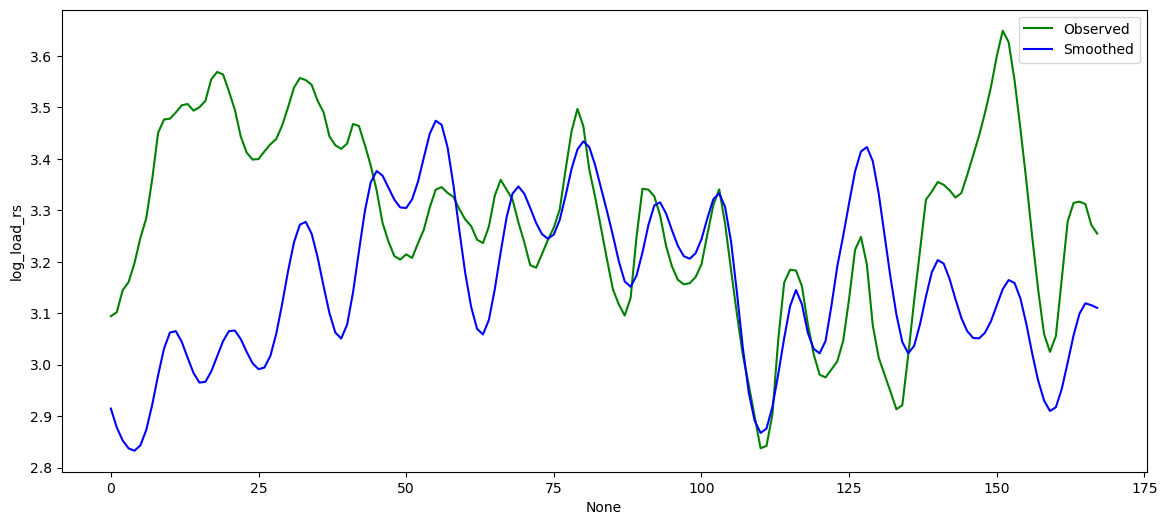

In [24]:
# Repeating the signal for last week of training in test
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=load_long_z1_jan04_test.reset_index().index, y=load_long_z1_jan04_test.reset_index().log_load_rs, ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jan04_test.reset_index().index, y=np.array(y_pred), ax=ax, color = "blue", label= "Smoothed")
plt.show()

Signal prediction is massively off-track.

In [26]:
# Performance on test data
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.0515631113888335
MSE score: 0.0626578952674245
MAE score: 0.19659270581431532
MAPE score: 0.05854314767442102


Performance on test data is very bad, changing the <i>frac</i> parameter should likely improve performance.

In [21]:
# 25 obs window in terms of % of training data - 12 hour prior and after focal point
print(2500/len(load_long_z1_jan04_train))

4.340277777777778


In [27]:
# Using 25 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0434, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.0939862300254988
MSE score: 0.0639535626098999
MAE score: 0.200493891952799
MAPE score: 0.059850905558053454


The performance is even worse when frac is enlarged.

In [23]:
# 15 obs window in terms of % of training data - 7 hour prior and after focal point
print(1500/len(load_long_z1_jan04_train))

2.6041666666666665


In [28]:
# Using 15 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.026, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.0375724749980795
MSE score: 0.062230599697120054
MAE score: 0.1988662155967321
MAPE score: 0.05930121015269828


Slightly improved performance.

In [30]:
# Using 13 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.02257, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
from sklearn.metrics import mean_squared_error
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.034235558648494
MSE score: 0.06212868513549248
MAE score: 0.19783298651880243
MAPE score: 0.0589609451712462


In [31]:
# Using 11 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0190, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.0376632213548915
MSE score: 0.062233371230537404
MAE score: 0.19678809425936492
MAPE score: 0.05861700249328592


In [32]:
# Using 17 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0295, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.0481795719824318
MSE score: 0.06255455676587776
MAE score: 0.19975530786964524
MAPE score: 0.059595077326993706


In [33]:
# Using 7 obs window

lowess = sm.nonparametric.lowess
x = load_long_z1_jan04_train.index
y = load_long_z1_jan04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.01215, it=0, is_sorted=True) 

# predicted values - replicating signal
y_pred = pd.DataFrame(lowess_vals).loc[:,1][575-168:575].reset_index(drop=True)

# Performance on test data
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs, np.array(y_pred))}')

R2 score: -1.07472757354367
MSE score: 0.06336537359727291
MAE score: 0.19729151160556702
MAPE score: 0.05876465948290648


Best performing is one with 13 observations so far. But even with that, R2 score is negative.

#### Testing on Last Week of Apr 2004 (Zone 1)
The smoothed loess curve is replicated and used for the test period.

In [34]:
# Filtering for Apr 2004 (Zone 1)
load_long_z1_apr04 = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 4),["year","month","day","hour","timestamp","log_load_rs"]].sort_values(by = "timestamp").reset_index(drop=True)

# Defining train and test
load_long_z1_apr04_train = load_long_z1_apr04.loc[load_long_z1_apr04.day < 24,:]
load_long_z1_apr04_test = load_long_z1_apr04.loc[load_long_z1_apr04.day >= 24,:].reset_index(drop = True)

# 9 obs window in terms of % of training data
900/len(load_long_z1_apr04_train)

1.6304347826086956

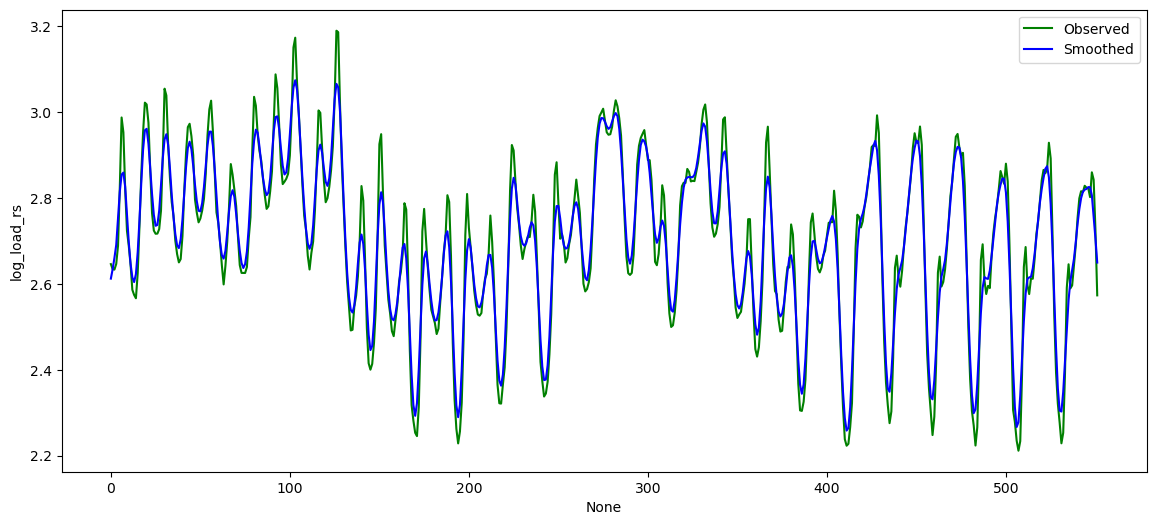

In [35]:
# Using 1.56% of total values i.e. 9 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_apr04_train.index
y = load_long_z1_apr04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0163, it=0, is_sorted=True) 

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=load_long_z1_apr04_train, x=load_long_z1_apr04_train.index, y="log_load_rs", ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_apr04_train.index, y=pd.DataFrame(lowess_vals).loc[:,1], ax=ax, color = "blue", label= "Smoothed")
plt.show()

In [38]:
# Model fit - training
print(f"R2 score: {r2_score(load_long_z1_apr04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_train.log_load_rs, pd.DataFrame(lowess_vals).loc[:,1])}')

R2 score: 0.9468408817023347
MSE score: 0.0021131543375588506
MAE score: 0.03505122614051878
MAPE score: 0.013115384292837366


In [39]:
# % for different window length
frac = [
    5/len(load_long_z1_apr04_train),
    7/len(load_long_z1_apr04_train),
    9/len(load_long_z1_apr04_train),
    11/len(load_long_z1_apr04_train),
    13/len(load_long_z1_apr04_train),
    15/len(load_long_z1_apr04_train),
    17/len(load_long_z1_apr04_train),
    19/len(load_long_z1_apr04_train),
    21/len(load_long_z1_apr04_train)
]

frac

[0.009057971014492754,
 0.012681159420289856,
 0.016304347826086956,
 0.019927536231884056,
 0.02355072463768116,
 0.02717391304347826,
 0.030797101449275364,
 0.034420289855072464,
 0.03804347826086957]

In [43]:
# Performance scores based on window

lowess = sm.nonparametric.lowess

for i in frac:
    x = load_long_z1_apr04_train.index
    y = load_long_z1_apr04_train.log_load_rs
    lowess_vals = lowess(y, x, frac=i, it=0, is_sorted=True) 
    y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_apr04_train)-168:len(load_long_z1_apr04_train)].reset_index(drop=True)
    print(f'The R2, MSE, MAE, MAPE for frac value {i} is: {round(r2_score(load_long_z1_apr04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_squared_error(load_long_z1_apr04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_error(load_long_z1_apr04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_percentage_error(load_long_z1_apr04_test.reset_index().log_load_rs, np.array(y_pred)),2)}')

The R2, MSE, MAE, MAPE for frac value 0.009057971014492754 is: 0.23 & 0.03 & 0.13 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.012681159420289856 is: 0.23 & 0.03 & 0.13 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.016304347826086956 is: 0.22 & 0.03 & 0.14 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.019927536231884056 is: 0.21 & 0.03 & 0.14 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.02355072463768116 is: 0.19 & 0.03 & 0.14 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.02717391304347826 is: 0.17 & 0.03 & 0.14 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.030797101449275364 is: 0.14 & 0.03 & 0.15 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.034420289855072464 is: 0.11 & 0.03 & 0.15 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.03804347826086957 is: 0.08 & 0.03 & 0.15 & 0.06


Best frac values here are smaller values, 7 obs or 9 obs.

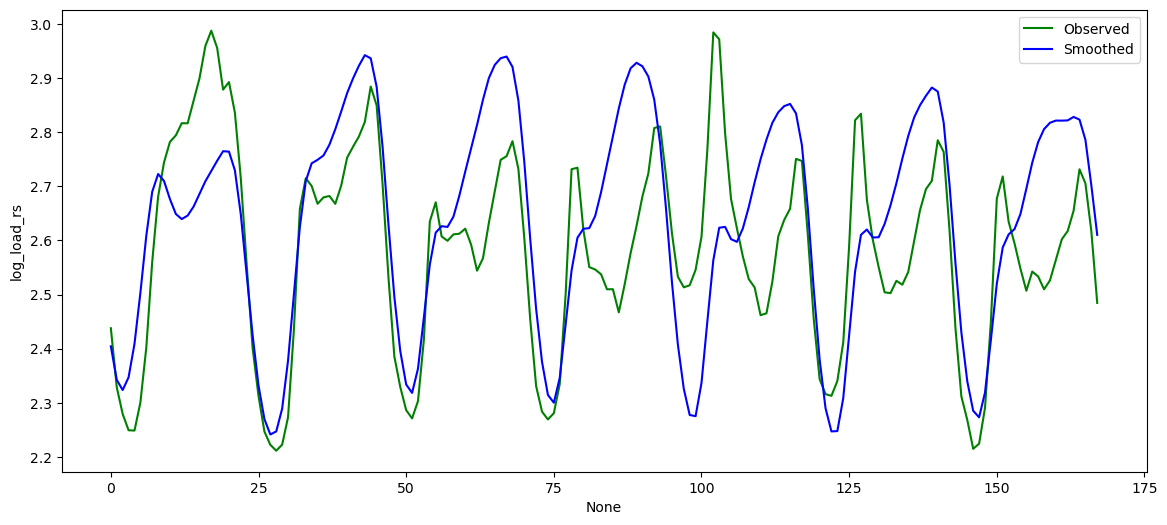

In [44]:
# Using 7 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_apr04_train.index
y = load_long_z1_apr04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.0126, it=0, is_sorted=True) 
y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_apr04_train)-168:len(load_long_z1_apr04_train)].reset_index(drop=True)

# Repeating the signal for last week of training in test
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=load_long_z1_apr04_test.reset_index().index, y=load_long_z1_apr04_test.reset_index().log_load_rs, ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_apr04_test.reset_index().index, y=np.array(y_pred), ax=ax, color = "blue", label= "Smoothed")
plt.show()

With 7 obs moving window, the R2 score on test set is 0.231 and MSE is 0.026

#### Testing on Last Week of Jul 2004 (Zone 1)
The smoothed loess curve is replicated and used for the test period.

In [45]:
# Filtering for Jul 2004 (Zone 1)
load_long_z1_jul04 = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 7),["year","month","day","hour","timestamp","log_load_rs"]].sort_values(by = "timestamp").reset_index(drop=True)

# Defining train and test
load_long_z1_jul04_train = load_long_z1_jul04.loc[load_long_z1_jul04.day <= 24,:]
load_long_z1_jul04_test = load_long_z1_jul04.loc[load_long_z1_jul04.day > 24,:].reset_index(drop = True)

# % for different window length
frac = [
    5/len(load_long_z1_jul04_train),
    7/len(load_long_z1_jul04_train),
    9/len(load_long_z1_jul04_train),
    11/len(load_long_z1_jul04_train),
    13/len(load_long_z1_jul04_train),
    15/len(load_long_z1_jul04_train),
    17/len(load_long_z1_jul04_train),
    19/len(load_long_z1_jul04_train),
    21/len(load_long_z1_jul04_train)
]

frac

[0.008680555555555556,
 0.012152777777777778,
 0.015625,
 0.019097222222222224,
 0.022569444444444444,
 0.026041666666666668,
 0.029513888888888888,
 0.03298611111111111,
 0.036458333333333336]

In [46]:
# Performance scores based on window
lowess = sm.nonparametric.lowess

for i in frac:
    x = load_long_z1_jul04_train.index
    y = load_long_z1_jul04_train.log_load_rs
    lowess_vals = lowess(y, x, frac=i, it=0, is_sorted=True) 
    y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_jul04_train)-168:len(load_long_z1_jul04_train)].reset_index(drop=True)
    print(f'The R2, MSE, MAE, MAPE for frac value {i} is: {round(r2_score(load_long_z1_jul04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_squared_error(load_long_z1_jul04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_error(load_long_z1_jul04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_percentage_error(load_long_z1_jul04_test.reset_index().log_load_rs, np.array(y_pred)),2)}')

The R2, MSE, MAE, MAPE for frac value 0.008680555555555556 is: 0.86 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.012152777777777778 is: 0.87 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.015625 is: 0.87 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.019097222222222224 is: 0.88 & 0.01 & 0.07 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.022569444444444444 is: 0.88 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.026041666666666668 is: 0.87 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.029513888888888888 is: 0.85 & 0.01 & 0.09 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.03298611111111111 is: 0.82 & 0.01 & 0.09 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.036458333333333336 is: 0.79 & 0.02 & 0.1 & 0.04


Here we see that in scenarios where periodicity is high, such as summer seasons, signal reciprocation from past data works as a good forecasting tool.<br>
Window with 11 and 13 observations appear to have highest R2 scores.

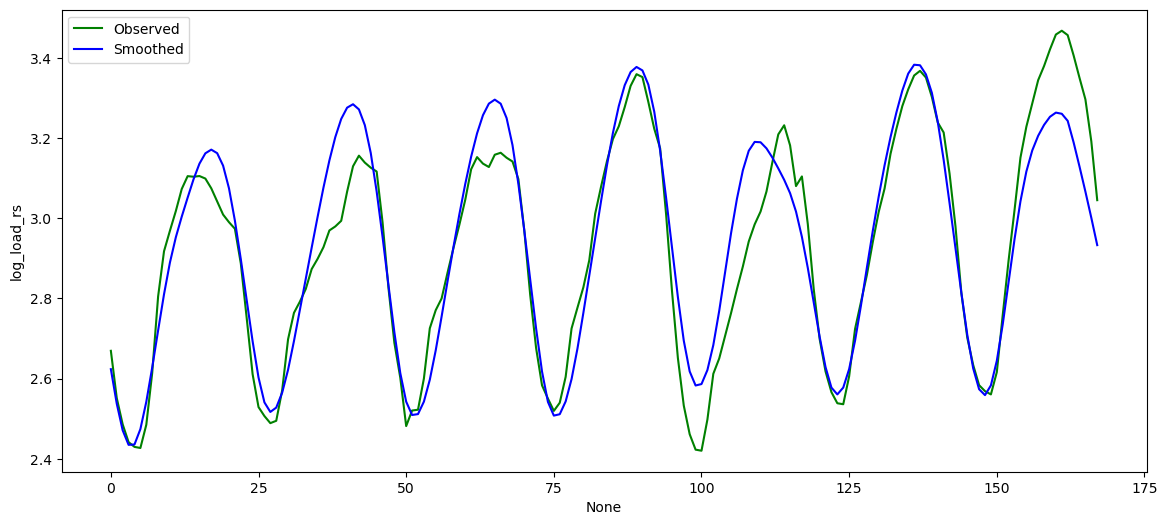

In [47]:
# Using 11 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_jul04_train.index
y = load_long_z1_jul04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.019097222222222224, it=0, is_sorted=True) 
y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_jul04_train)-168:len(load_long_z1_jul04_train)].reset_index(drop=True)

# Repeating the signal for last week of training in test
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=load_long_z1_jul04_test.reset_index().index, y=load_long_z1_jul04_test.reset_index().log_load_rs, ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_jul04_test.reset_index().index, y=np.array(y_pred), ax=ax, color = "blue", label= "Smoothed")
plt.show()

With 11 obs moving window, the R2 score on test set is 0.877

#### Testing on Last Week of Oct 2004 (Zone 1)
The smoothed loess curve is replicated and used for the test period.

In [48]:
# Filtering for Oct 2004 (Zone 1)
load_long_z1_oct04 = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 10),["year","month","day","hour","timestamp","log_load_rs"]].sort_values(by = "timestamp").reset_index(drop=True)

# Defining train and test
load_long_z1_oct04_train = load_long_z1_oct04.loc[load_long_z1_oct04.day <= 24,:]
load_long_z1_oct04_test = load_long_z1_oct04.loc[load_long_z1_oct04.day > 24,:].reset_index(drop = True)

# % for different window length
frac = [
    5/len(load_long_z1_oct04_train),
    7/len(load_long_z1_oct04_train),
    9/len(load_long_z1_oct04_train),
    11/len(load_long_z1_oct04_train),
    13/len(load_long_z1_oct04_train),
    15/len(load_long_z1_oct04_train),
    17/len(load_long_z1_oct04_train),
    19/len(load_long_z1_oct04_train),
    21/len(load_long_z1_oct04_train)
]

frac

[0.008680555555555556,
 0.012152777777777778,
 0.015625,
 0.019097222222222224,
 0.022569444444444444,
 0.026041666666666668,
 0.029513888888888888,
 0.03298611111111111,
 0.036458333333333336]

In [49]:
# Performance scores based on window
lowess = sm.nonparametric.lowess

for i in frac:
    x = load_long_z1_oct04_train.index
    y = load_long_z1_oct04_train.log_load_rs
    lowess_vals = lowess(y, x, frac=i, it=0, is_sorted=True) 
    y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_oct04_train)-168:len(load_long_z1_oct04_train)].reset_index(drop=True)
    print(f'The R2, MSE, MAE, MAPE for frac value {i} is: {round(r2_score(load_long_z1_oct04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_squared_error(load_long_z1_oct04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_error(load_long_z1_oct04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_percentage_error(load_long_z1_oct04_test.reset_index().log_load_rs, np.array(y_pred)),2)}')

The R2, MSE, MAE, MAPE for frac value 0.008680555555555556 is: 0.7 & 0.01 & 0.07 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.012152777777777778 is: 0.69 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.015625 is: 0.65 & 0.01 & 0.08 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.019097222222222224 is: 0.6 & 0.01 & 0.09 & 0.03
The R2, MSE, MAE, MAPE for frac value 0.022569444444444444 is: 0.53 & 0.01 & 0.09 & 0.04
The R2, MSE, MAE, MAPE for frac value 0.026041666666666668 is: 0.44 & 0.02 & 0.1 & 0.04
The R2, MSE, MAE, MAPE for frac value 0.029513888888888888 is: 0.35 & 0.02 & 0.11 & 0.04
The R2, MSE, MAE, MAPE for frac value 0.03298611111111111 is: 0.25 & 0.02 & 0.12 & 0.05
The R2, MSE, MAE, MAPE for frac value 0.036458333333333336 is: 0.16 & 0.02 & 0.12 & 0.05


Signal reciprocation from past data works as a good forecasting tool here too.<br>
Window with 5 and 7 observations appear to have highest R2 scores.

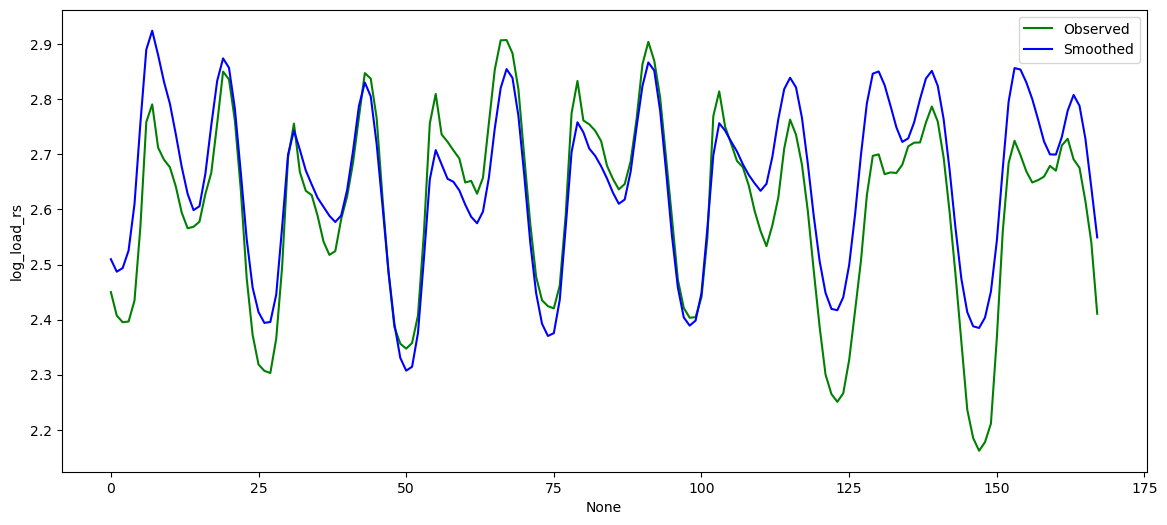

In [50]:
# Using 5 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_oct04_train.index
y = load_long_z1_oct04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.008680555555555556, it=0, is_sorted=True) 
y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_oct04_train)-168:len(load_long_z1_oct04_train)].reset_index(drop=True)

# Repeating the signal for last week of training in test
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=load_long_z1_oct04_test.reset_index().index, y=load_long_z1_oct04_test.reset_index().log_load_rs, ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_oct04_test.reset_index().index, y=np.array(y_pred), ax=ax, color = "blue", label= "Smoothed")
plt.show()

With 5 obs moving window, the R2 score is 0.7 on test data and MSE is 0.008.

#### Testing on Last Week of Dec 2004 (Zone 1)
The smoothed loess curve is replicated and used for the test period.

In [51]:
# Filtering for Dec 2004 (Zone 1)
load_long_z1_dec04 = load_long_z1.loc[(load_long_z1.year == 2004) & (load_long_z1.month == 12),["year","month","day","hour","timestamp","log_load_rs"]].sort_values(by = "timestamp").reset_index(drop=True)

# Defining train and test
load_long_z1_dec04_train = load_long_z1_dec04.loc[load_long_z1_dec04.day <= 24,:]
load_long_z1_dec04_test = load_long_z1_dec04.loc[load_long_z1_dec04.day > 24,:].reset_index(drop = True)

# % for different window length
frac = [
    5/len(load_long_z1_dec04_train),
    7/len(load_long_z1_dec04_train),
    9/len(load_long_z1_dec04_train),
    11/len(load_long_z1_dec04_train),
    13/len(load_long_z1_dec04_train),
    15/len(load_long_z1_dec04_train),
    17/len(load_long_z1_dec04_train),
    19/len(load_long_z1_dec04_train),
    21/len(load_long_z1_dec04_train)
]

frac

[0.008680555555555556,
 0.012152777777777778,
 0.015625,
 0.019097222222222224,
 0.022569444444444444,
 0.026041666666666668,
 0.029513888888888888,
 0.03298611111111111,
 0.036458333333333336]

In [52]:
# Performance scores based on window
lowess = sm.nonparametric.lowess

for i in frac:
    x = load_long_z1_dec04_train.index
    y = load_long_z1_dec04_train.log_load_rs
    lowess_vals = lowess(y, x, frac=i, it=0, is_sorted=True) 
    y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_dec04_train)-168:len(load_long_z1_dec04_train)].reset_index(drop=True)
    print(f'The R2, MSE, MAE, MAPE for frac value {i} is: {round(r2_score(load_long_z1_dec04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_squared_error(load_long_z1_dec04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_error(load_long_z1_dec04_test.reset_index().log_load_rs, np.array(y_pred)),2)} & {round(mean_absolute_percentage_error(load_long_z1_dec04_test.reset_index().log_load_rs, np.array(y_pred)),2)}')

The R2, MSE, MAE, MAPE for frac value 0.008680555555555556 is: -0.18 & 0.06 & 0.2 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.012152777777777778 is: -0.18 & 0.06 & 0.2 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.015625 is: -0.19 & 0.06 & 0.2 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.019097222222222224 is: -0.2 & 0.06 & 0.2 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.022569444444444444 is: -0.23 & 0.06 & 0.2 & 0.06
The R2, MSE, MAE, MAPE for frac value 0.026041666666666668 is: -0.26 & 0.06 & 0.2 & 0.07
The R2, MSE, MAE, MAPE for frac value 0.029513888888888888 is: -0.29 & 0.06 & 0.2 & 0.07
The R2, MSE, MAE, MAPE for frac value 0.03298611111111111 is: -0.32 & 0.06 & 0.21 & 0.07
The R2, MSE, MAE, MAPE for frac value 0.036458333333333336 is: -0.35 & 0.06 & 0.21 & 0.07


In winter months, reproducing past signal as forecast becomes a poor choice.

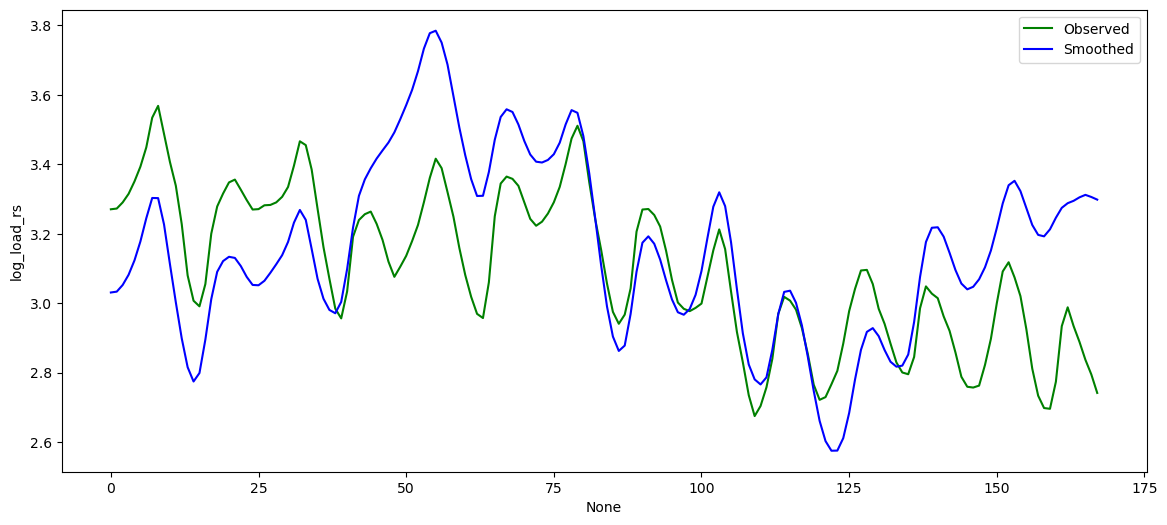

In [53]:
# Using 5 obs moving window

lowess = sm.nonparametric.lowess
x = load_long_z1_dec04_train.index
y = load_long_z1_dec04_train.log_load_rs
lowess_vals = lowess(y, x, frac=0.008680555555555556, it=0, is_sorted=True) 
y_pred = pd.DataFrame(lowess_vals).loc[:,1][len(load_long_z1_dec04_train)-168:len(load_long_z1_dec04_train)].reset_index(drop=True)

# Repeating the signal for last week of training in test
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x=load_long_z1_dec04_test.reset_index().index, y=load_long_z1_dec04_test.reset_index().log_load_rs, ax=ax, color = "green", label= "Observed")
sns.lineplot(x=load_long_z1_dec04_test.reset_index().index, y=np.array(y_pred), ax=ax, color = "blue", label= "Smoothed")
plt.show()

Using lowess the following R2, MSE, MAE and MAPE scores are observed during the tested portions of the year:
- Jan'04: -1.03 | 0.06 | xxx | xxx
- Apr'04: 0.23 | 0.026 | xxx | xxx
- Jul'04: 0.87 | 0.009 | xxx | xxx
- Oct'04: 0.70 | 0.008 | xxx | xxx
- Dec'04: -0.18 | 0.05 | xxx | xxx

## Naive Methods
Simple methods to get an idea of baseline performance on test set.

### Repeating the last cycle
The exact values from the latest past are used as prediction, using the same training and test data as defined before.

In [57]:
# Jan 2004 (Zone 1)
y_pred = np.array(load_long_z1_jan04_train.log_load_rs[len(load_long_z1_jan04_train)-168:len(load_long_z1_jan04_train)])

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')

R2 score: -1.0566899787427326
MSE score: 0.06281447768788591
MAE score: 0.19490351721989305
MAPE score: 0.058225651516824475


In [58]:
# Apr 2004 (Zone 1)
y_pred = np.array(load_long_z1_apr04_train.log_load_rs[len(load_long_z1_apr04_train)-168:len(load_long_z1_apr04_train)])

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_apr04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')

R2 score: 0.22579133170164678
MSE score: 0.02648264719386805
MAE score: 0.13250699259599966
MAPE score: 0.05075046170548208


In [59]:
# Jul 2004 (Zone 1)
y_pred = np.array(load_long_z1_jul04_train.log_load_rs[len(load_long_z1_jul04_train)-168:len(load_long_z1_jul04_train)])

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')

R2 score: 0.8565489927364498
MSE score: 0.011329149174500907
MAE score: 0.08596940254933513
MAPE score: 0.029137801651107565


In [60]:
# Oct 2004 (Zone 1)
y_pred = np.array(load_long_z1_oct04_train.log_load_rs[len(load_long_z1_oct04_train)-168:len(load_long_z1_oct04_train)])

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')

R2 score: 0.705743760771753
MSE score: 0.008309077205834285
MAE score: 0.07340581158087518
MAPE score: 0.0288378693481896


In [61]:
# Dec 2004 (Zone 1)
y_pred = np.array(load_long_z1_dec04_train.log_load_rs[len(load_long_z1_dec04_train)-168:len(load_long_z1_dec04_train)])

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')

R2 score: -0.18362454522590754
MSE score: 0.05553992617613542
MAE score: 0.19744061634608526
MAPE score: 0.0640827607707658


Here again we see that only when periodicity in data is particularly strong (such as Jul 2004), repeating past values as prediction works well.
<br>
R2, MSE, MAE and MAPE scores (in this order) for tested periods are as follows:
- Jan'04: -1.05 | 0.06 | xxx | xxx
- Apr'04: 0.22 | 0.02 | xxx | xxx
- Jul'04: 0.85 | 0.01 | xxx | xxx
- Oct'04: 0.70 | 0.008 | xxx | xxx
- Dec'04: -0.18 | 0.05 | xxx | xxx

Loess smoothing and prediction without smoothing have very similar performance on test data (both R2 and MSE scores), both only doing well when periodicity is very high and dominates the movement in hourly load (such as July 2004). In winter period, performance on test set deteriorates.

### Seasonal Naive
The length of the season is one day (24 hrs). Hence, the last day of training data is used as forecast for every day in the test set.

#### January 2004

In [69]:
# Last available day
print(load_long_z1_jan04_train.day[-1:])

575    24
Name: day, dtype: int64


In [75]:
# length of test set
len(load_long_z1_jan04_test)

168

In [76]:
# Multiples to create
168/24

7.0

In [82]:
# Jan 2004 (Zone 1)
y_pred = np.tile(np.array(load_long_z1_jan04_train.loc[load_long_z1_jan04_train.day == 24, "log_load_rs"]), 7)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')

R2 score: -1.515883091890037
MSE score: 0.07683894217127622
MAE score: 0.23154074083098922
MAPE score: 0.06871871499972604


#### April 2004

In [84]:
# Last available day
print(load_long_z1_apr04_train.day[-1:])

# length of test set
len(load_long_z1_apr04_test)

551    23
Name: day, dtype: int64


168

In [85]:
# Apr 2004 (Zone 1)
y_pred = np.tile(np.array(load_long_z1_apr04_train.loc[load_long_z1_apr04_train.day == 23, "log_load_rs"]), 7)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_apr04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')

R2 score: 0.2951678088710231
MSE score: 0.024109549547637603
MAE score: 0.12083760309888085
MAPE score: 0.04671213734393592


#### July 2004

In [86]:
# Last available day
print(load_long_z1_jul04_train.day[-1:])

# length of test set
len(load_long_z1_jul04_test)

575    24
Name: day, dtype: int64


168

In [87]:
# Jul 2004 (Zone 1)
y_pred = np.tile(np.array(load_long_z1_jul04_train.loc[load_long_z1_jul04_train.day == 24, "log_load_rs"]), 7)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')

R2 score: 0.8087855490808578
MSE score: 0.015101302389625556
MAE score: 0.10157405293760767
MAPE score: 0.03464475908806012


#### Oct 2004

In [88]:
# Last available day
print(load_long_z1_oct04_train.day[-1:])

# length of test set
len(load_long_z1_oct04_test)

575    24
Name: day, dtype: int64


168

In [89]:
# Oct 2004 (Zone 1)
y_pred = np.tile(np.array(load_long_z1_oct04_train.loc[load_long_z1_oct04_train.day == 24, "log_load_rs"]), 7)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')

R2 score: 0.49762739509730114
MSE score: 0.014185774857928324
MAE score: 0.09980699998250309
MAPE score: 0.038539252626599234


#### Dec 2004

In [90]:
# Last available day
print(load_long_z1_dec04_train.day[-1:])

# length of test set
len(load_long_z1_dec04_test)

575    24
Name: day, dtype: int64


168

In [91]:
# Dec 2004 (Zone 1)
y_pred = np.tile(np.array(load_long_z1_dec04_train.loc[load_long_z1_dec04_train.day == 24, "log_load_rs"]), 7)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')

R2 score: -0.35291643614877777
MSE score: 0.06348371135869094
MAE score: 0.21128300524587185
MAPE score: 0.07079213391924556


### Average of Training Data (Latest Cycle)
The mean is not calculated for the entire training set, but only the most recent cycle.

In [97]:
# Jan 2004 (Zone 1)
y_pred = np.tile(np.mean(load_long_z1_jan04_train.log_load_rs[len(load_long_z1_jan04_train)-168:len(load_long_z1_jan04_train)]),168)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')

R2 score: -0.51680021835114
MSE score: 0.04632541338624191
MAE score: 0.17943163253041122
MAPE score: 0.05361535817656284


In [98]:
# Apr 2004 (Zone 1)
y_pred = np.tile(np.mean(load_long_z1_apr04_train.log_load_rs[len(load_long_z1_apr04_train)-168:len(load_long_z1_apr04_train)]),168)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_apr04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')

R2 score: -0.08047917728672704
MSE score: 0.03695896213006282
MAE score: 0.1523835868538716
MAPE score: 0.06108855070660774


In [99]:
# Jul 2004 (Zone 1)
y_pred = np.tile(np.mean(load_long_z1_jul04_train.log_load_rs[len(load_long_z1_jul04_train)-168:len(load_long_z1_jul04_train)]),168)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')

R2 score: -0.0016473030078540951
MSE score: 0.07910583503372777
MAE score: 0.24201104991105113
MAPE score: 0.08471400663506883


In [100]:
# Oct 2004 (Zone 1)
y_pred = np.tile(np.mean(load_long_z1_oct04_train.log_load_rs[len(load_long_z1_oct04_train)-168:len(load_long_z1_oct04_train)]),168)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')

R2 score: -0.06897429293716018
MSE score: 0.030185222085222445
MAE score: 0.1326865011792122
MAPE score: 0.053151792933956325


In [101]:
# Dec 2004 (Zone 1)
y_pred = np.tile(np.mean(load_long_z1_dec04_train.log_load_rs[len(load_long_z1_dec04_train)-168:len(load_long_z1_dec04_train)]),168)

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')

R2 score: -0.07501155160287554
MSE score: 0.05044341337406192
MAE score: 0.19090794644012926
MAPE score: 0.06329412153440162


### Hourly Average - from training (3 weeks)
Taking average at every hour from the entire training data available.

#### January 2004

In [107]:
# Specifying hours
hour_array = load_long_z1_jan04_train.hour.unique()
hour_array

array(['00:30', '01:30', '02:30', '03:30', '04:30', '05:30', '06:30',
       '07:30', '08:30', '09:30', '10:30', '11:30', '12:30', '13:30',
       '14:30', '15:30', '16:30', '17:30', '18:30', '19:30', '20:30',
       '21:30', '22:30', '23:30'], dtype=object)

In [111]:
# Initializing an empty dictionary
hourly_avg = {}

# We use enumerate to get both the index (i) and the key (month_name)
for i, hour in enumerate(hour_array):
    # Ensure we don't go out of bounds for the last element's "next index"
    if i + 1 < len(hour_array):
        next_index = i + 1
    else:
        # Use a placeholder or special calculation for the last item
        next_index = i

    # Define the formula to calculate the value (e.g., simple running average)
    avg_value = np.mean(load_long_z1_jan04_train.loc[load_long_z1_jan04_train.hour == hour,"log_load_rs"])

    # Add the key-value pair to the dictionary
    hourly_avg[hour] = avg_value

print(hourly_avg)

{'00:30': 2.977447602810843, '01:30': 2.969662714205592, '02:30': 2.9815715098356654, '03:30': 3.0023292176331355, '04:30': 3.0362865938936827, '05:30': 3.1112198452632307, '06:30': 3.212260274332755, '07:30': 3.254834726448467, '08:30': 3.2197133661720603, '09:30': 3.152183844055197, '10:30': 3.081659444316594, '11:30': 3.0103793818818514, '12:30': 2.957326138762759, '13:30': 2.915778872238672, '14:30': 2.8837437610380228, '15:30': 2.884412207252298, '16:30': 2.945943062808137, '17:30': 3.0799509945221106, '18:30': 3.1635060024452515, '19:30': 3.1722097835847602, '20:30': 3.1664807550421457, '21:30': 3.1277019441015024, '22:30': 3.0617692721749825, '23:30': 3.003118567927349}


In [119]:
# Creating predictions: per hour avg values (from training)

pred_list = []

for i in load_long_z1_jan04_test.hour:
    pred_list.append(hourly_avg[i])

print(len(pred_list))
y_pred = pred_list
pred_list[0:5]

168


[2.977447602810843,
 2.969662714205592,
 2.9815715098356654,
 3.0023292176331355,
 3.0362865938936827]

In [120]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.log_load_rs, y_pred)}')

R2 score: -1.491564736971489
MSE score: 0.07609622218030752
MAE score: 0.2292819581032861
MAPE score: 0.06809848728529477


#### April 2004

In [121]:
# Initializing an empty dictionary
hourly_avg = {}

# We use enumerate to get both the index (i) and the key (month_name)
for i, hour in enumerate(hour_array):
    # Ensure we don't go out of bounds for the last element's "next index"
    if i + 1 < len(hour_array):
        next_index = i + 1
    else:
        # Use a placeholder or special calculation for the last item
        next_index = i

    # Define the formula to calculate the value (e.g., simple running average)
    avg_value = np.mean(load_long_z1_apr04_train.loc[load_long_z1_apr04_train.hour == hour,"log_load_rs"])

    # Add the key-value pair to the dictionary
    hourly_avg[hour] = avg_value

print(hourly_avg)

{'00:30': 2.5209926198364347, '01:30': 2.482213814538323, '02:30': 2.468528860661517, '03:30': 2.4745475604436296, '04:30': 2.5171660155274167, '05:30': 2.630026118453392, '06:30': 2.7879525391776205, '07:30': 2.848098082891405, '08:30': 2.8203265395243133, '09:30': 2.782292998321191, '10:30': 2.7483271910449263, '11:30': 2.713970816028913, '12:30': 2.702234087973821, '13:30': 2.6926975751757, '14:30': 2.6818679092656343, '15:30': 2.691229361685076, '16:30': 2.7248223268492184, '17:30': 2.7632824018366047, '18:30': 2.792237928118515, '19:30': 2.82762310344987, '20:30': 2.888276463860455, '21:30': 2.854519216804767, '22:30': 2.745004462351828, '23:30': 2.612532685581114}


In [122]:
# Creating predictions: per hour avg values (from training)

pred_list = []

for i in load_long_z1_apr04_test.hour:
    pred_list.append(hourly_avg[i])

y_pred = pred_list

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_apr04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.log_load_rs, y_pred)}')

R2 score: 0.20465068049971347
MSE score: 0.027205786097052837
MAE score: 0.14253636272029502
MAPE score: 0.056883776155167806


#### July 2004

In [123]:
# Initializing an empty dictionary
hourly_avg = {}

# We use enumerate to get both the index (i) and the key (month_name)
for i, hour in enumerate(hour_array):
    # Ensure we don't go out of bounds for the last element's "next index"
    if i + 1 < len(hour_array):
        next_index = i + 1
    else:
        # Use a placeholder or special calculation for the last item
        next_index = i

    # Define the formula to calculate the value (e.g., simple running average)
    avg_value = np.mean(load_long_z1_jul04_train.loc[load_long_z1_jul04_train.hour == hour,"log_load_rs"])

    # Add the key-value pair to the dictionary
    hourly_avg[hour] = avg_value

print(hourly_avg)

{'00:30': 2.7526692385245624, '01:30': 2.6399938867339974, '02:30': 2.5652205703521047, '03:30': 2.5144227064759925, '04:30': 2.5014433352522816, '05:30': 2.53991578306102, '06:30': 2.6302336177520655, '07:30': 2.726836127045825, '08:30': 2.8417528049595595, '09:30': 2.9600425404842348, '10:30': 3.064111355672631, '11:30': 3.1427677281872506, '12:30': 3.206103790221382, '13:30': 3.259714509498487, '14:30': 3.2975262887633687, '15:30': 3.328504679097376, '16:30': 3.350591668704331, '17:30': 3.3678342209354004, '18:30': 3.353680647860314, '19:30': 3.2943802567571914, '20:30': 3.2335499082211108, '21:30': 3.1966030301386827, '22:30': 3.075063479831137, '23:30': 2.913213155586542}


In [124]:
# Creating predictions: per hour avg values (from training)

pred_list = []

for i in load_long_z1_jul04_test.hour:
    pred_list.append(hourly_avg[i])

y_pred = pred_list

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.log_load_rs, y_pred)}')

R2 score: 0.7864886051781801
MSE score: 0.01686221999088592
MAE score: 0.10255416872437048
MAPE score: 0.034900179359558414


#### October 2004

In [125]:
# Initializing an empty dictionary
hourly_avg = {}

# We use enumerate to get both the index (i) and the key (month_name)
for i, hour in enumerate(hour_array):
    # Ensure we don't go out of bounds for the last element's "next index"
    if i + 1 < len(hour_array):
        next_index = i + 1
    else:
        # Use a placeholder or special calculation for the last item
        next_index = i

    # Define the formula to calculate the value (e.g., simple running average)
    avg_value = np.mean(load_long_z1_oct04_train.loc[load_long_z1_oct04_train.hour == hour,"log_load_rs"])

    # Add the key-value pair to the dictionary
    hourly_avg[hour] = avg_value

print(hourly_avg)

{'00:30': 2.4112129851552115, '01:30': 2.3583849052801535, '02:30': 2.3373935324128507, '03:30': 2.341763033424727, '04:30': 2.371696357279047, '05:30': 2.4811083192321393, '06:30': 2.6496504794970863, '07:30': 2.722777500531215, '08:30': 2.7171395610409625, '09:30': 2.7136944287897933, '10:30': 2.697859799437277, '11:30': 2.6708274274644914, '12:30': 2.6491217721446123, '13:30': 2.6363856898788263, '14:30': 2.6177515076693374, '15:30': 2.631174721448103, '16:30': 2.677100424267792, '17:30': 2.7326284254509794, '18:30': 2.7835388499900753, '19:30': 2.846248649966007, '20:30': 2.8285350795504165, '21:30': 2.7556742404623837, '22:30': 2.640334859422421, '23:30': 2.5162595169131894}


In [126]:
# Creating predictions: per hour avg values (from training)

pred_list = []

for i in load_long_z1_oct04_test.hour:
    pred_list.append(hourly_avg[i])

y_pred = pred_list

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.log_load_rs, y_pred)}')

R2 score: 0.7849950955566766
MSE score: 0.006071213155371233
MAE score: 0.059509722495082386
MAPE score: 0.023383838275391818


#### December 2004

In [127]:
# Initializing an empty dictionary
hourly_avg = {}

# We use enumerate to get both the index (i) and the key (month_name)
for i, hour in enumerate(hour_array):
    # Ensure we don't go out of bounds for the last element's "next index"
    if i + 1 < len(hour_array):
        next_index = i + 1
    else:
        # Use a placeholder or special calculation for the last item
        next_index = i

    # Define the formula to calculate the value (e.g., simple running average)
    avg_value = np.mean(load_long_z1_dec04_train.loc[load_long_z1_dec04_train.hour == hour,"log_load_rs"])

    # Add the key-value pair to the dictionary
    hourly_avg[hour] = avg_value

print(hourly_avg)

{'00:30': 2.900126215219784, '01:30': 2.886695573958994, '02:30': 2.8912490261411876, '03:30': 2.9127415505314658, '04:30': 2.957285152708492, '05:30': 3.0456684714581463, '06:30': 3.1630355748588155, '07:30': 3.2006442169436653, '08:30': 3.1597967486181813, '09:30': 3.0874802160223687, '10:30': 3.0113898073431833, '11:30': 2.9299008729387044, '12:30': 2.8687349668703335, '13:30': 2.823673811187815, '14:30': 2.8032643106166084, '15:30': 2.8224499427958416, '16:30': 2.918666672132273, '17:30': 3.0831963477722772, '18:30': 3.13845069338916, '19:30': 3.151328259864497, '20:30': 3.147694684958303, '21:30': 3.1131561922132307, '22:30': 3.047427002151687, '23:30': 2.9743301059594427}


In [128]:
# Creating predictions: per hour avg values (from training)

pred_list = []

for i in load_long_z1_dec04_test.hour:
    pred_list.append(hourly_avg[i])

y_pred = pred_list

# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.log_load_rs, y_pred)}")
print(f'MSE score: {mean_squared_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.log_load_rs, y_pred)}')

R2 score: 0.03127404253612309
MSE score: 0.0454561105372996
MAE score: 0.18362598954122156
MAPE score: 0.0580664291537887


## Exponential Smoothing - Holt Winter's Method
Additive seasonal model is used, since the amplitude of seasonality is not proportional to the average level of the series. <br>
[Reference](https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873)

In [129]:
# seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   

# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### Testing on last week of Jan 2004 (Zone 1)
Data is first decomposed.
<br>
Length of training can influence decomposition, hence only the last week of original training data is kept for model fitting.

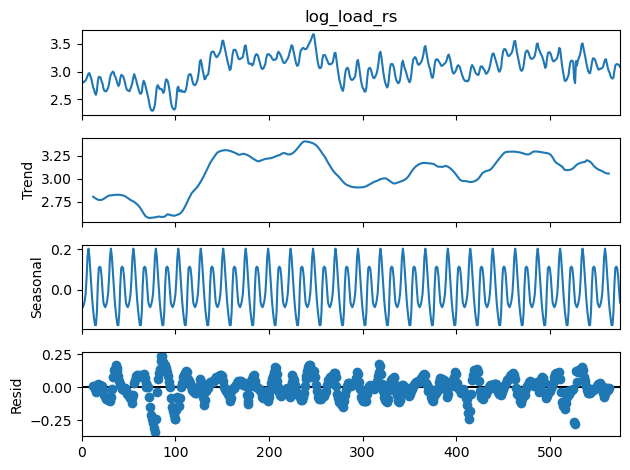

In [130]:
# Visualising decomposition - training, Jan 2004 (Zone 1)

decompose = seasonal_decompose(
    load_long_z1_jan04_train["log_load_rs"], 
    model="additive",
    period=24
)

import matplotlib.pyplot as plt
decompose.plot()
plt.show()

It is seen from the seasonal decomposition that there is no clear trend i.e. level increase or decrease with passage of time.

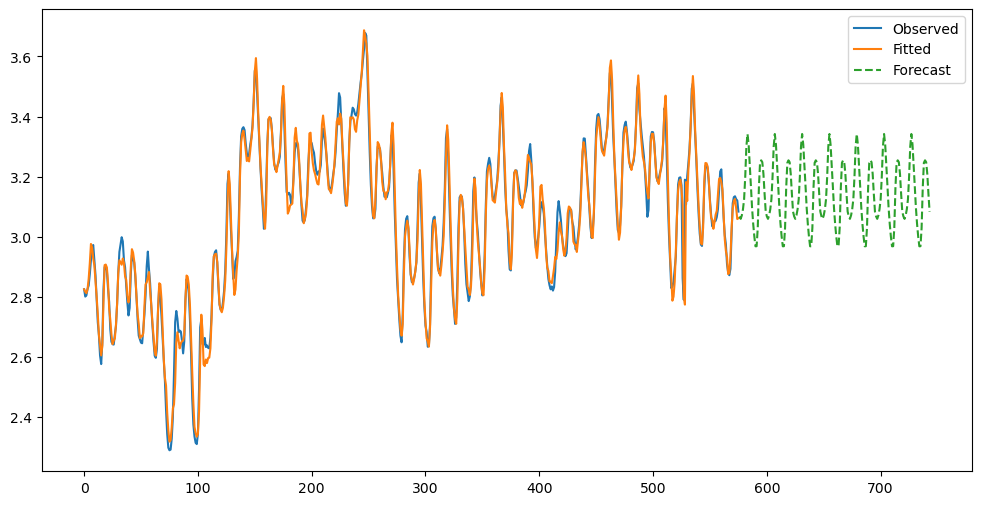

In [131]:
# Applying HW Exponential Smoothing, trend + seasonality

hw_model = ExponentialSmoothing(
    load_long_z1_jan04_train["log_load_rs"],
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jan04_train["log_load_rs"], label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

In [132]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')

R2 score: -0.4772108435331641
MSE score: 0.04511629294179782
MAE score: 0.17224504576919197
MAPE score: 0.051331313108887174


Performance is better than both lowess and last signal prediction, but still not as strong.

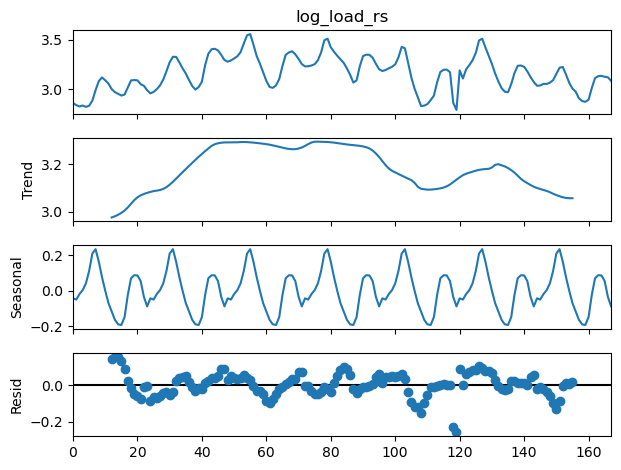

In [133]:
# Can changing training to only 3rd week of Jan improve performance?

decompose = seasonal_decompose(
    load_long_z1_jan04_train.loc[(load_long_z1_jan04_train.timestamp <= '2004-01-24 23:30:00') & (load_long_z1_jan04_train.timestamp > '2004-01-17 23:30:00'),"log_load_rs"].reset_index(drop=True), 
    model="additive",
    period=24
)

decompose.plot()
plt.show()

There is no clear direction for <i>trend</i>. Holt Winter's method requires <i>trend</i> to have a clear direction, if it is to be added in the model.

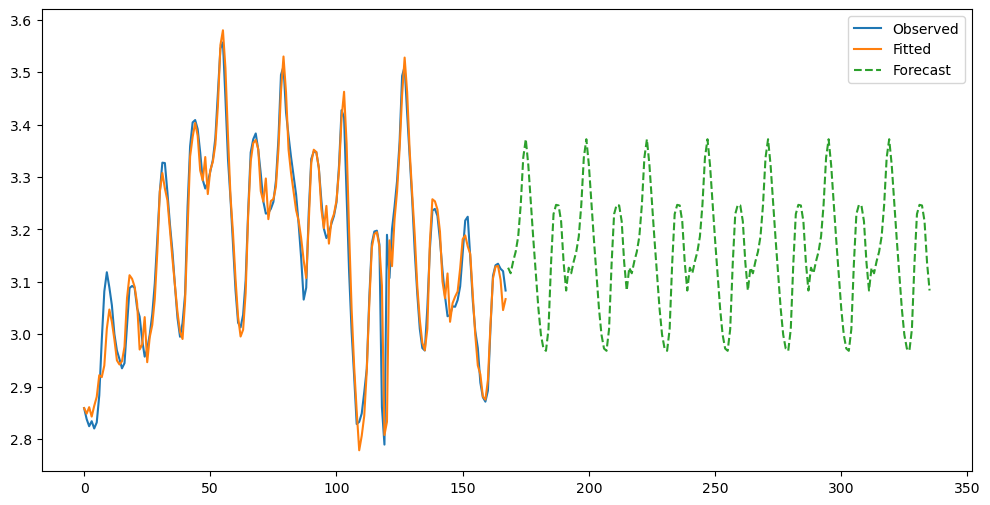

In [134]:
hw_model = ExponentialSmoothing(
    load_long_z1_jan04_train.loc[(load_long_z1_jan04_train.timestamp <= '2004-01-24 23:30:00') & (load_long_z1_jan04_train.timestamp > '2004-01-17 23:30:00'),"log_load_rs"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jan04_train.loc[(load_long_z1_jan04_train.timestamp <= '2004-01-24 23:30:00') & (load_long_z1_jan04_train.timestamp > '2004-01-17 23:30:00'),"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

In [135]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jan04_test.reset_index().log_load_rs ,forecast)}')

R2 score: -0.35547348720037597
MSE score: 0.041398246696528175
MAE score: 0.16295395722643247
MAPE score: 0.048608150418774594


Performance slightly improved.

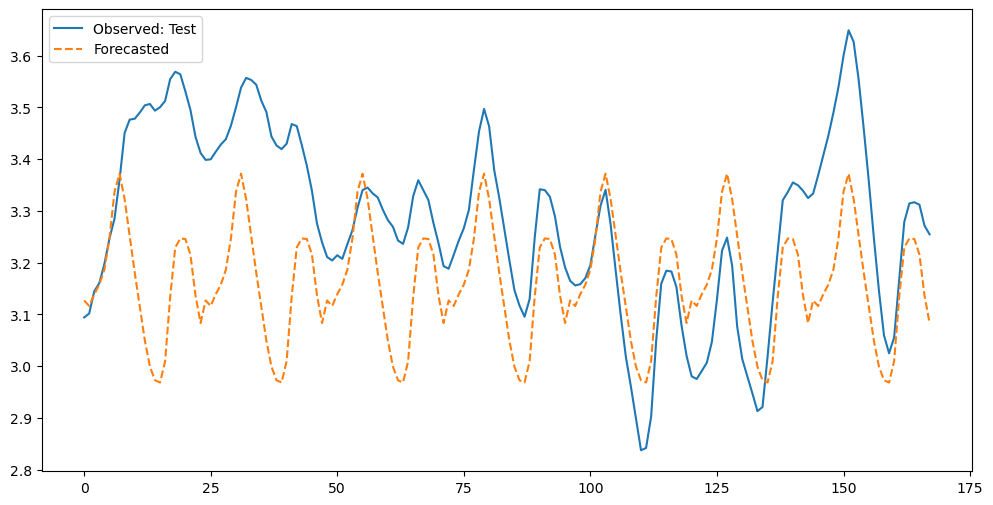

In [136]:
# Plotting Forecasted vs Observed - Test Set

plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jan04_test.reset_index(drop=True).log_load_rs, label="Observed: Test")
plt.plot(forecast.reset_index(drop=True), label="Forecasted", linestyle="--")
plt.legend()
plt.show()

Trend appears to be deviated, with some some deviation in seasonality as well.
<br>
Adding <i>trend</i> in the model actually results in a slightly poorer performance.

#### Testing on last week of Apr 2004 (Zone 1)
Data is first decomposed.
<br>
Length of training can influence decomposition, hence only the last week of original training data is kept for model fitting.

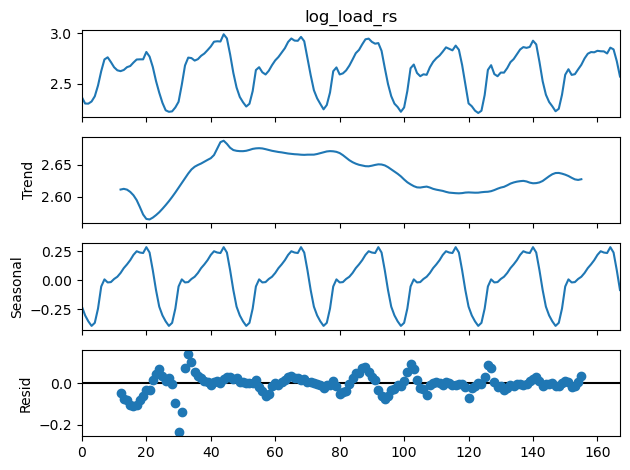

In [137]:
# Visualising decomposition - last week of training, Apr 2004 (Zone 1)

decompose = seasonal_decompose(
    load_long_z1_apr04_train.loc[load_long_z1_apr04_train.timestamp >= '2004-04-17 00:30:00' ,"log_load_rs"].reset_index(drop=True), 
    model="additive",
    period=24
)

decompose.plot()
plt.show()

It's again seen that <i>trend</i> isn't very clear. It initially increase but later stabilises.

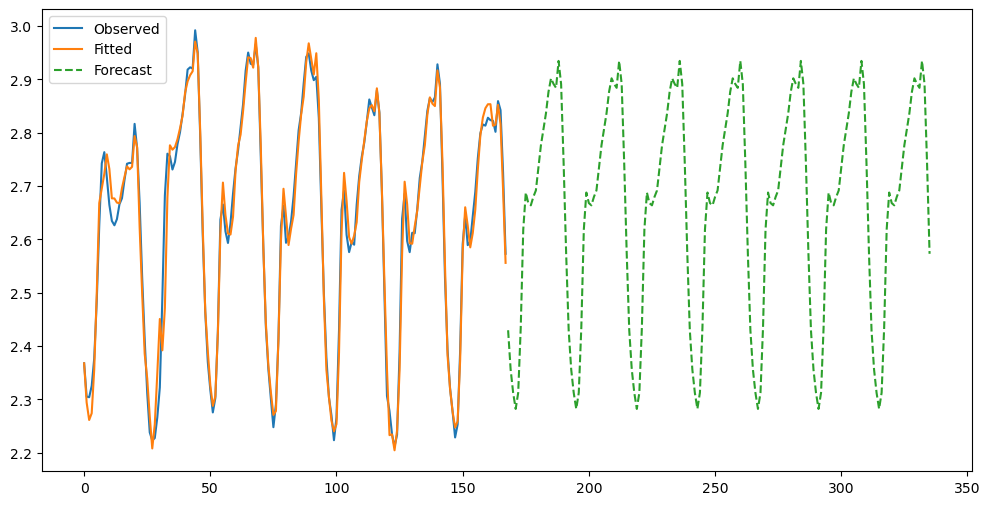

In [138]:
hw_model = ExponentialSmoothing(
    load_long_z1_apr04_train.loc[load_long_z1_apr04_train.timestamp >= '2004-04-17 00:30:00' ,"log_load_rs"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_apr04_train.loc[load_long_z1_apr04_train.timestamp >= '2004-04-17 00:30:00' ,"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

In [139]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_apr04_test.reset_index(drop=True).log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_apr04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_apr04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_apr04_test.reset_index(drop=True).log_load_rs ,forecast)}')

R2 score: 0.21123716348309163
MSE score: 0.02698048830300902
MAE score: 0.13208558020775873
MAPE score: 0.051170270871572325


Both R2 and MSE scores are very similar to loess + past signal reciprocation approaches.

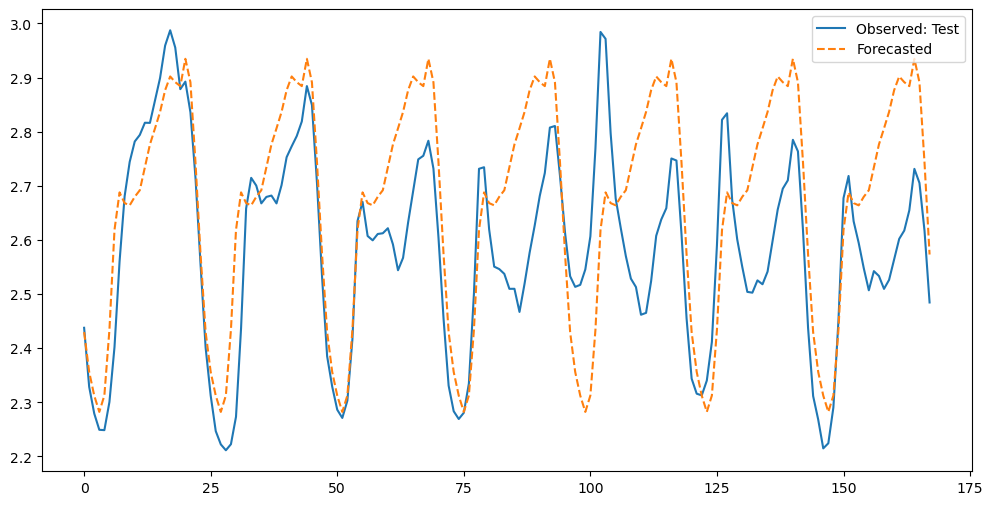

In [140]:
# Plotting Forecasted vs Observed - Test Set

plt.figure(figsize=(12,6))
plt.plot(load_long_z1_apr04_test.reset_index(drop=True).log_load_rs, label="Observed: Test")
plt.plot(forecast.reset_index(drop=True), label="Forecasted", linestyle="--")
plt.legend()
plt.show()

Level appears more or less okay, main issue appears to be lack of capturing seasonality appropriately.

#### Testing on last week of Jul 2004 (Zone 1)
Data is first decomposed.
<br>
Length of training can influence decomposition, hence only the last week of original training data is kept for model fitting.

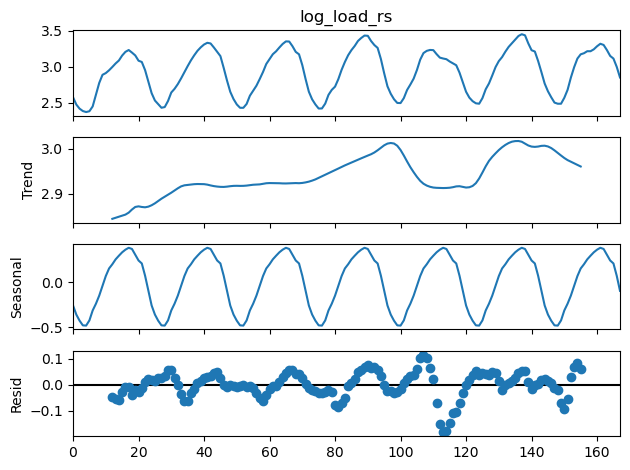

In [141]:
# Visualising decomposition - last week of training, Jul 2004 (Zone 1)

decompose = seasonal_decompose(
    load_long_z1_jul04_train.loc[load_long_z1_jul04_train.timestamp >= '2004-07-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), 
    model="additive",
    period=24
)

decompose.plot()
plt.show()

A positive trend can be seen here, although not fully explicit.

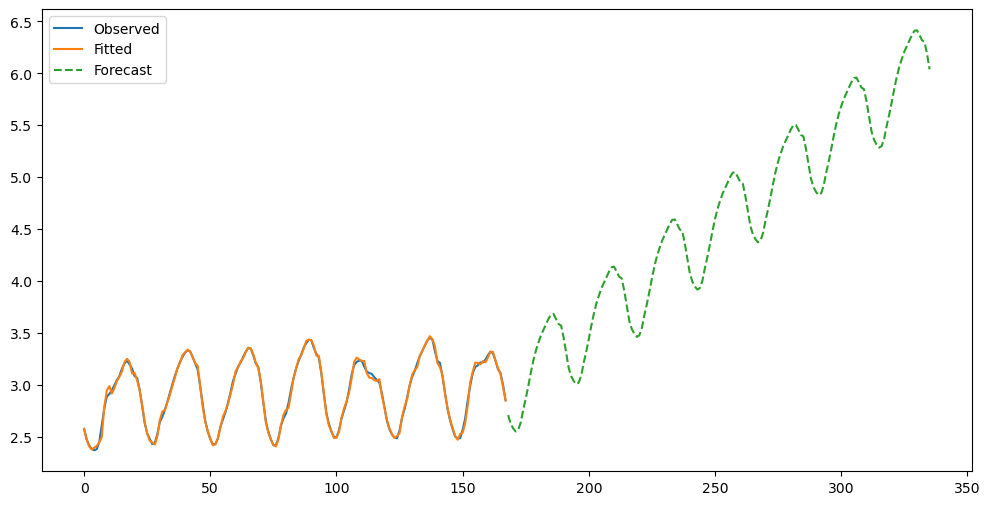

In [142]:
hw_model = ExponentialSmoothing(
    load_long_z1_jul04_train.loc[load_long_z1_jul04_train.timestamp >= '2004-07-18 00:30:00' ,"log_load_rs"].reset_index(drop=True),
    trend='add',
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jul04_train.loc[load_long_z1_jul04_train.timestamp >= '2004-07-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

The captured trend appears to be way too steep. Removing the trend should be considered.

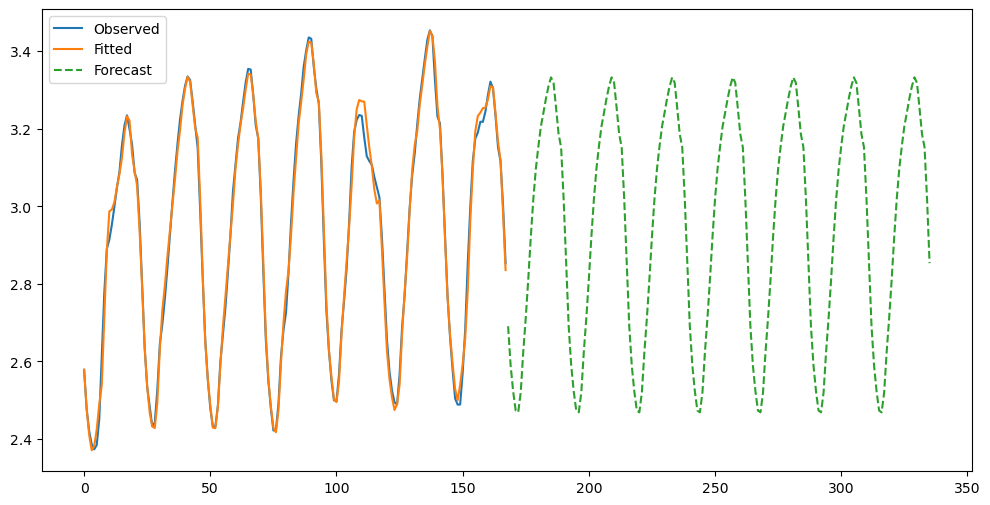

In [143]:
hw_model = ExponentialSmoothing(
    load_long_z1_jul04_train.loc[load_long_z1_jul04_train.timestamp >= '2004-07-18 00:30:00' ,"log_load_rs"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jul04_train.loc[load_long_z1_jul04_train.timestamp >= '2004-07-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

This appears to be much more appropriate.

In [144]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_jul04_test.reset_index(drop=True).log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_jul04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_jul04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_jul04_test.reset_index(drop=True).log_load_rs ,forecast)}')

R2 score: 0.8434364470991316
MSE score: 0.01236472214409117
MAE score: 0.08767818199376105
MAPE score: 0.029648961763356397


When periodicity is strong, prediction is straightforward as seen here.<br>
The performance is very similar to loess + past signal reciprocation approaches, no clear advantage.

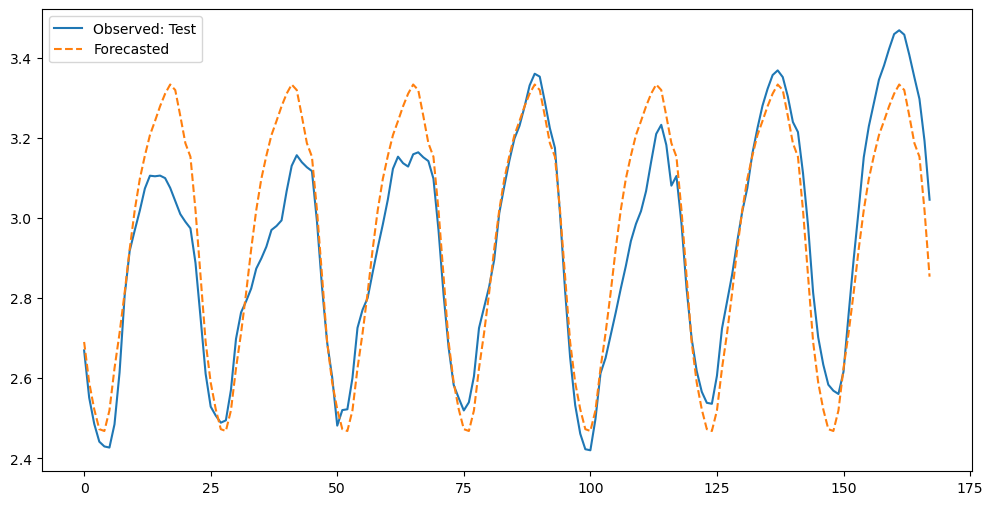

In [145]:
# Plotting Forecasted vs Observed - Test Set

plt.figure(figsize=(12,6))
plt.plot(load_long_z1_jul04_test.reset_index(drop=True).log_load_rs, label="Observed: Test")
plt.plot(forecast.reset_index(drop=True), label="Forecasted", linestyle="--")
plt.legend()
plt.show()

#### Testing on last week of Oct 2004 (Zone 1)
Data is first decomposed.
<br>
Length of training can influence decomposition, hence only the last week of original training data is kept for model fitting.

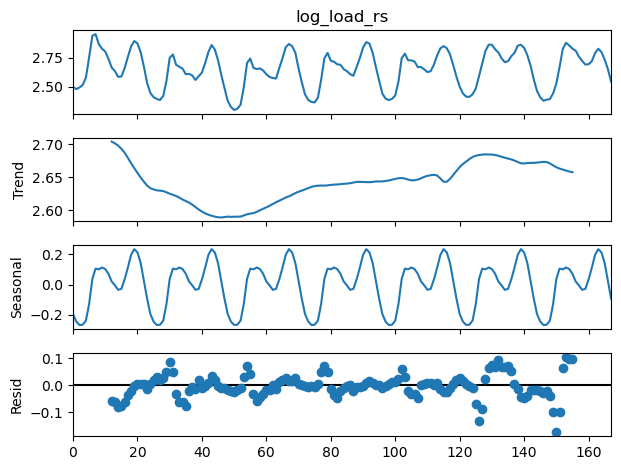

In [146]:
# Visualising decomposition - last week of training, Oct 2004 (Zone 1)

decompose = seasonal_decompose(
    load_long_z1_oct04_train.loc[load_long_z1_oct04_train.timestamp >= '2004-10-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), 
    model="additive",
    period=24
)

decompose.plot()
plt.show()

No clear trend is visible.

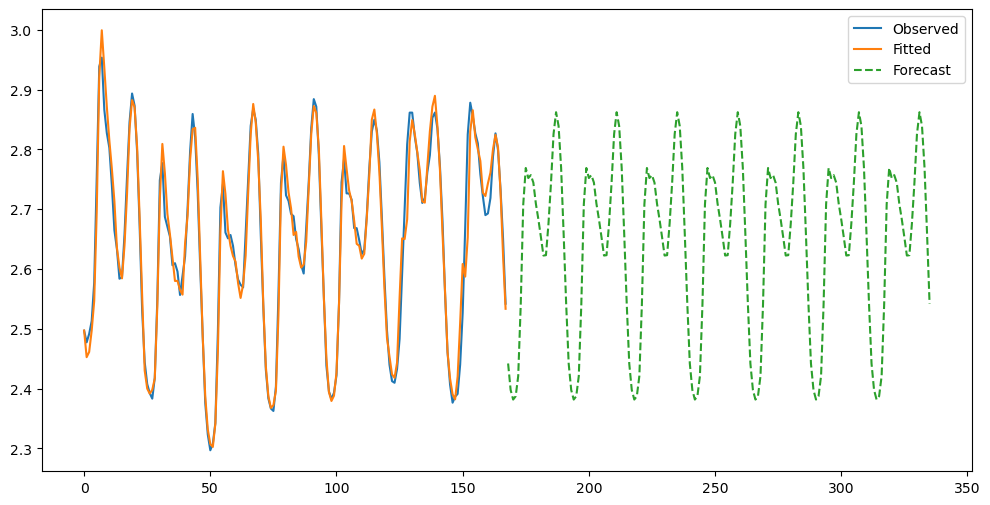

In [147]:
hw_model = ExponentialSmoothing(
    load_long_z1_oct04_train.loc[load_long_z1_oct04_train.timestamp >= '2004-10-18 00:30:00' ,"log_load_rs"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_oct04_train.loc[load_long_z1_oct04_train.timestamp >= '2004-10-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

In [148]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_oct04_test.reset_index(drop=True).log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_oct04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_oct04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_oct04_test.reset_index(drop=True).log_load_rs ,forecast)}')

R2 score: 0.7236591061045017
MSE score: 0.007803191628252614
MAE score: 0.06426046890957252
MAPE score: 0.025460147679768248


Performance is similar or very slightly better.

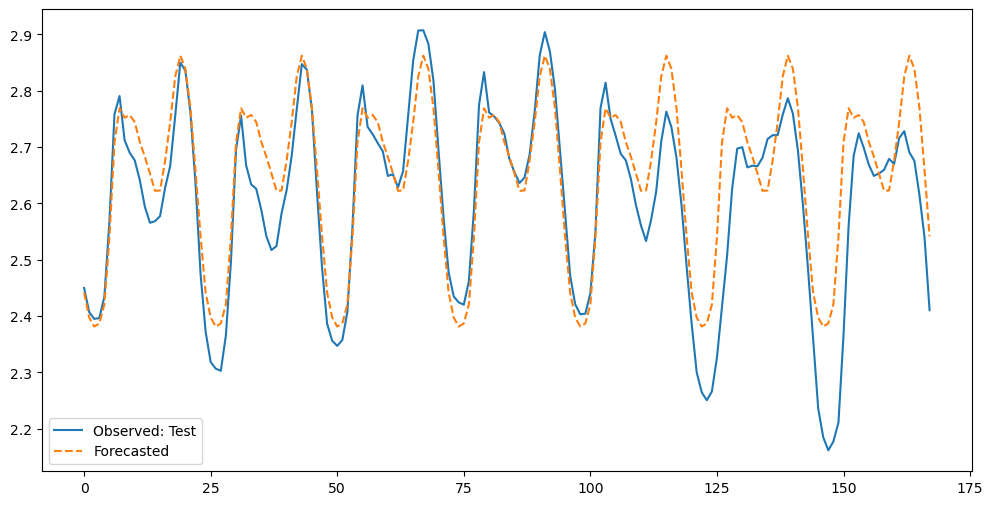

In [149]:
# Plotting Forecasted vs Observed - Test Set

plt.figure(figsize=(12,6))
plt.plot(load_long_z1_oct04_test.reset_index(drop=True).log_load_rs, label="Observed: Test")
plt.plot(forecast.reset_index(drop=True), label="Forecasted", linestyle="--")
plt.legend()
plt.show()

#### Testing on last week of Dec 2004 (Zone 1)
Data is first decomposed.
<br>
Length of training can influence decomposition, hence only the last week of original training data is kept for model fitting.

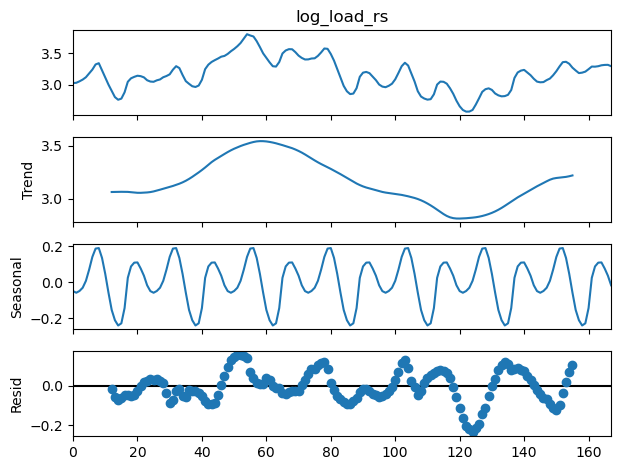

In [150]:
# Visualising decomposition - last week of training, Dec 2004 (Zone 1)

decompose = seasonal_decompose(
    load_long_z1_dec04_train.loc[load_long_z1_dec04_train.timestamp >= '2004-12-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), 
    model="additive",
    period=24
)

decompose.plot()
plt.show()

No clear direction for <i>trend.</i>
<br>
However, trend changes are considerable.

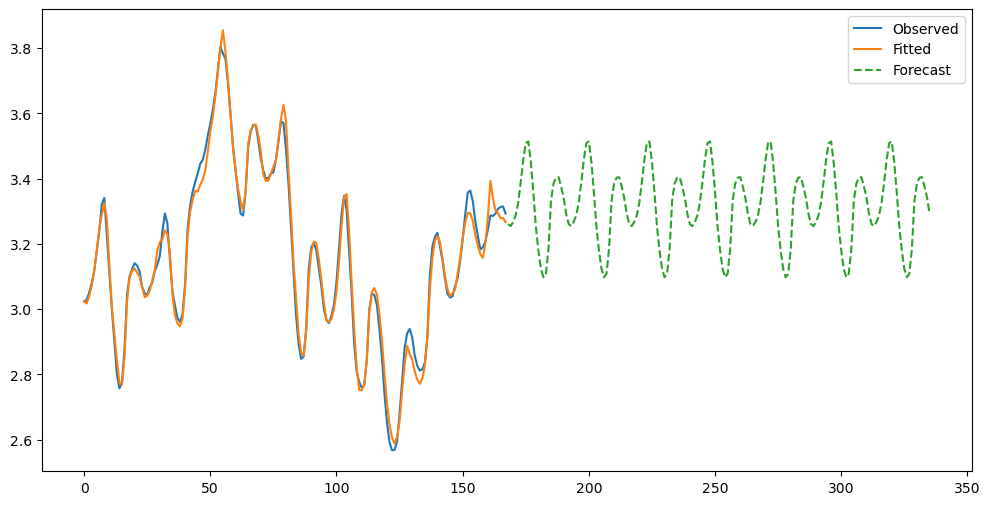

In [151]:
hw_model = ExponentialSmoothing(
    load_long_z1_dec04_train.loc[load_long_z1_dec04_train.timestamp >= '2004-12-18 00:30:00' ,"log_load_rs"].reset_index(drop=True),
    seasonal="add",         # additive seasonality
    seasonal_periods=24     # 24th hour i.e. daily seasonality
).fit()

# Forecast next week i.e. 24*7 periods
forecast = hw_model.forecast(24*7)
fitted = hw_model.fittedvalues

# Plotting
plt.figure(figsize=(12,6))
plt.plot(load_long_z1_dec04_train.loc[load_long_z1_dec04_train.timestamp >= '2004-12-18 00:30:00' ,"log_load_rs"].reset_index(drop=True), label="Observed")
plt.plot(fitted, label="Fitted")
plt.plot(forecast, label="Forecast", linestyle="--")
plt.legend()
plt.show()

In [152]:
# Performance on test set
print(f"R2 score: {r2_score(load_long_z1_dec04_test.reset_index(drop=True).log_load_rs ,forecast)}")
print(f'MSE score: {mean_squared_error(load_long_z1_dec04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAE score: {mean_absolute_error(load_long_z1_dec04_test.reset_index(drop=True).log_load_rs ,forecast)}')
print(f'MAPE score: {mean_absolute_percentage_error(load_long_z1_dec04_test.reset_index(drop=True).log_load_rs ,forecast)}')

R2 score: -0.6749263991375563
MSE score: 0.07859357845676081
MAE score: 0.22093316418658626
MAPE score: 0.07492538947394135


Performance is slightly better, but still very poor due to negative R2 score.

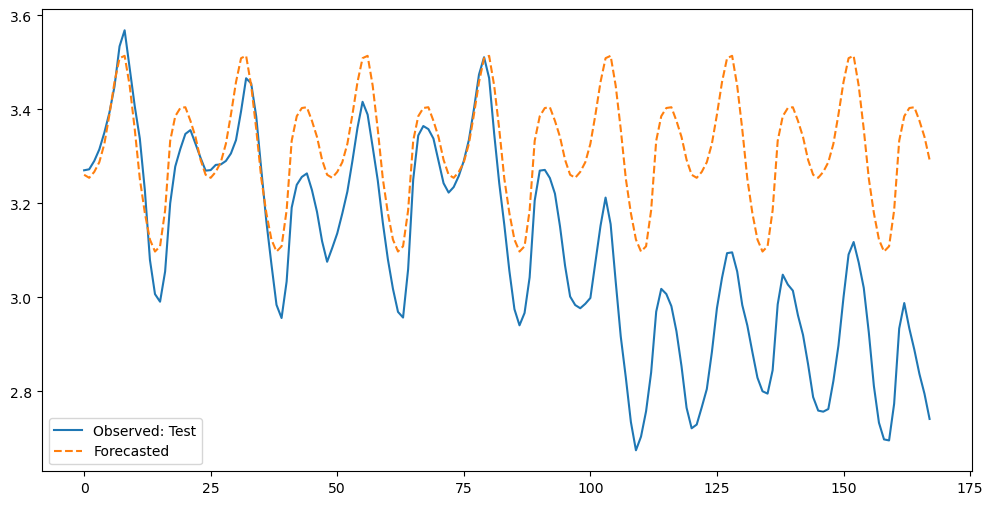

In [153]:
# Plotting Forecasted vs Observed - Test Set

plt.figure(figsize=(12,6))
plt.plot(load_long_z1_dec04_test.reset_index(drop=True).log_load_rs, label="Observed: Test")
plt.plot(forecast.reset_index(drop=True), label="Forecasted", linestyle="--")
plt.legend()
plt.show()

The <i>trend</i> appears to be slightly mismatched here.

### Conclusion
- It is seen that both smoothers i.e. Loess and ES are offering similar performance.
- With Loess, the smoothed curve is directly projected into the future for forecasting.
- Without any smoothing, the past values are also directly used as forecasted values.
- With ES, past values are not directly used. Instead, Holt Winter's method is used to capture seasonality and trend.
<br><br>
In a forecasting sense, the ES model is a true forecasting model since it is not completely repeating the past signal as it is. Due to the complex nature of seasonality and average level (i.e. trend), it can't perform any better than the previous methods.